In [11]:
# ---- Project Root Finder ----
import os
import sys


def find_and_set_project_root(project_name="tetrakis-sim"):
    cur = os.getcwd()
    while os.path.basename(cur) != project_name:
        parent = os.path.dirname(cur)
        if parent == cur:
            raise RuntimeError(f"Project root '{project_name}' not found!")
        cur = parent
    os.chdir(cur)
    if cur not in sys.path:
        sys.path.insert(0, cur)
    print("Project root set to:", cur)

find_and_set_project_root()

# ---- Imports ----
import math

import matplotlib.pyplot as plt
import networkx as nx

from tetrakis_sim.lattice import build_sheet


Project root set to: /Users/MWL/Desktop/tetrakis-sim


In [12]:
# ---- Parameters ----
size = 9        # width/height of each floor
layers = 5      # number of floors (z axis)
G = build_sheet(size=size, dim=3, layers=layers)

z_values = sorted(set(n[2] for n in G))
print(f"Floors (z values): {z_values}")


Floors (z values): [0, 1, 2, 3, 4]


In [13]:
def plot_floor(G, z, highlight_nodes=None, boundary_nodes=None, title=None, figsize=(7,7)):
    nodes_on_layer = [n for n in G if n[2] == z]
    H = G.subgraph(nodes_on_layer)
    def node_pos(node):
        r, c, z, q = node
        offset = 0.18 * "ABCD".index(q)
        return (r + offset, c + offset)
    pos = {n: node_pos(n) for n in nodes_on_layer}
    plt.figure(figsize=figsize)
    nx.draw(H, pos, node_size=60, with_labels=False, alpha=0.7)
    # Highlight removed (black hole) nodes as empty circles
    if highlight_nodes:
        nodes = [n for n in highlight_nodes if len(n) > 2 and n[2] == z]
        if nodes:
            def raw_node_pos(node):
                r, c, z, q = node
                offset = 0.18 * "ABCD".index(q)
                return (r + offset, c + offset)
            xs, ys = zip(*[raw_node_pos(n) for n in nodes])
            plt.scatter(xs, ys, s=200, c='none', edgecolors='black', linewidths=2, label='Black Hole (removed)', zorder=10)
    # Boundary nodes (event horizon)
    if boundary_nodes:
        nodes = [n for n in boundary_nodes if n[2] == z]
        if nodes:
            xs, ys = zip(*[pos[n] for n in nodes])
            plt.scatter(xs, ys, s=200, c='gold', edgecolors='red', label='Event Horizon', zorder=11)
    if title:
        plt.title(title)
    plt.axis('equal')
    plt.legend()
    plt.show()



In [14]:
# ---- Black Hole Application ----
def apply_blackhole_defect(G, center, radius):
    """Remove nodes within radius of center (2D or 3D). Return list of removed nodes."""
    nodes_to_remove = []
    if len(center) == 2:
        r0, c0 = center
        for node in list(G.nodes):
            r, c = node[:2]
            if math.hypot(r - r0, c - c0) < radius:
                nodes_to_remove.append(node)
    else:
        r0, c0, z0 = center
        for node in list(G.nodes):
            r, c, z = node[:3]
            if math.sqrt((r - r0)**2 + (c - c0)**2 + (z - z0)**2) < radius:
                nodes_to_remove.append(node)
    G.remove_nodes_from(nodes_to_remove)
    return nodes_to_remove


In [15]:
# ---- Find Event Horizon Nodes ----
def find_event_horizon(G, removed_nodes, radius, center):
    """Find nodes on the 'event horizon' (just outside black hole, adjacent to removed nodes)."""
    horizon = set()
    removed_set = set(removed_nodes)
    for node in G.nodes:
        # Distance check (within a shell near the boundary)
        dist = 0
        if len(center) == 2:
            r, c = node[:2]
            dist = math.hypot(r - center[0], c - center[1])
        else:
            r, c, z = node[:3]
            dist = math.sqrt((r - center[0])**2 + (c - center[1])**2 + (z - center[2])**2)
        if radius - 1 <= dist < radius + 1:
            # Adjacent to removed region?
            if any(neigh in removed_set for neigh in G.neighbors(node)):
                horizon.add(node)
    return list(horizon)


In [16]:
# ---- Parameters for Black Hole ----
bh_center = (size//2, size//2, layers//2)  # Center of lattice, 3D
bh_radius = 2.7

# ---- Apply Black Hole ----
removed_nodes = apply_blackhole_defect(G, bh_center, bh_radius)
horizon_nodes = find_event_horizon(G, removed_nodes, bh_radius, bh_center)

print(f"Black hole removed {len(removed_nodes)} nodes.")
print(f"Event horizon nodes: {len(horizon_nodes)}")


Black hole removed 324 nodes.
Event horizon nodes: 0


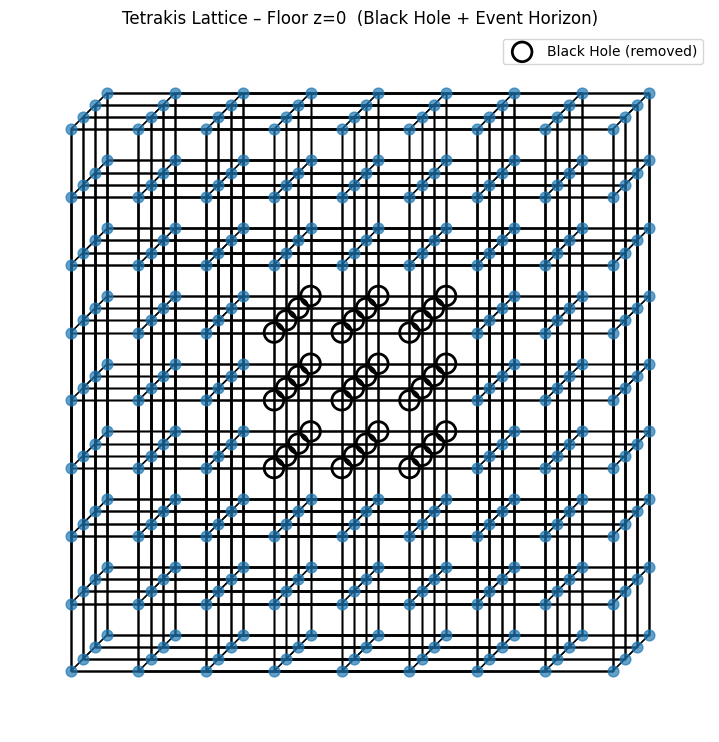

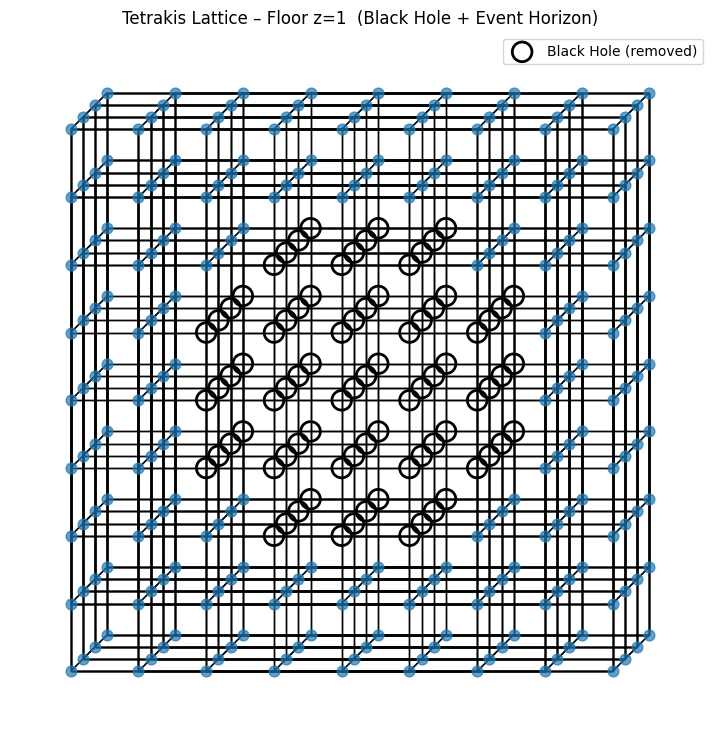

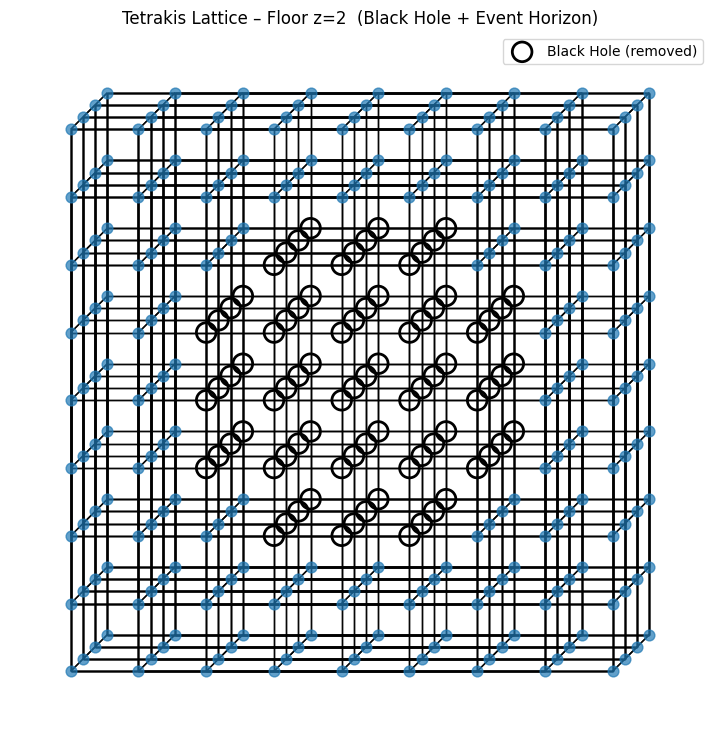

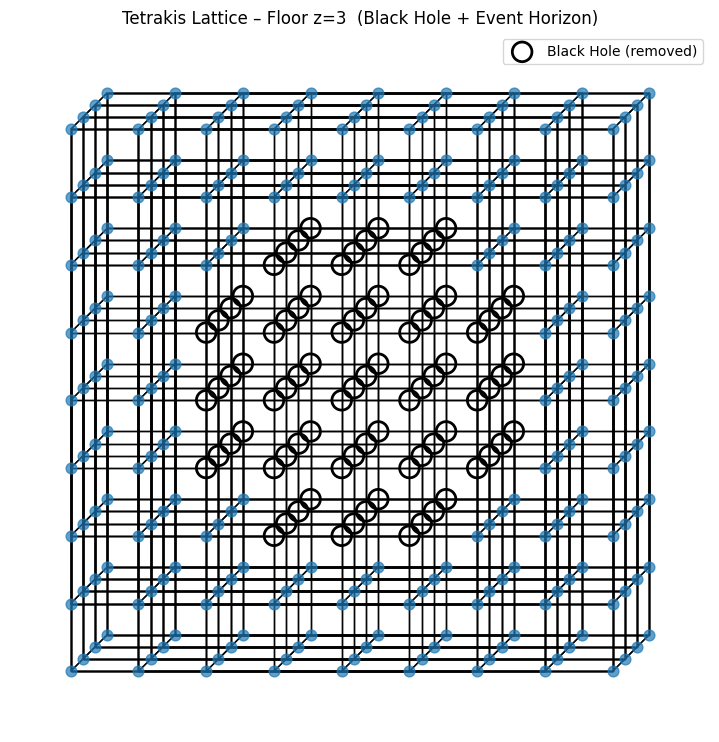

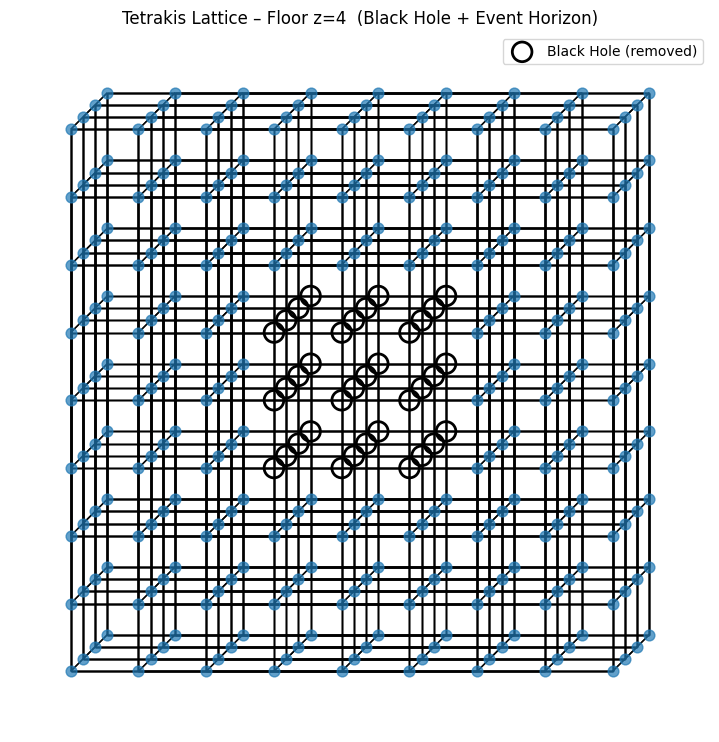

In [17]:
# ---- Plot each floor, showing black hole and event horizon ----
for z in z_values:
    plot_floor(
        G, z,
        highlight_nodes=removed_nodes,
        boundary_nodes=horizon_nodes,
        title=f"Tetrakis Lattice – Floor z={z}  (Black Hole + Event Horizon)"
    )


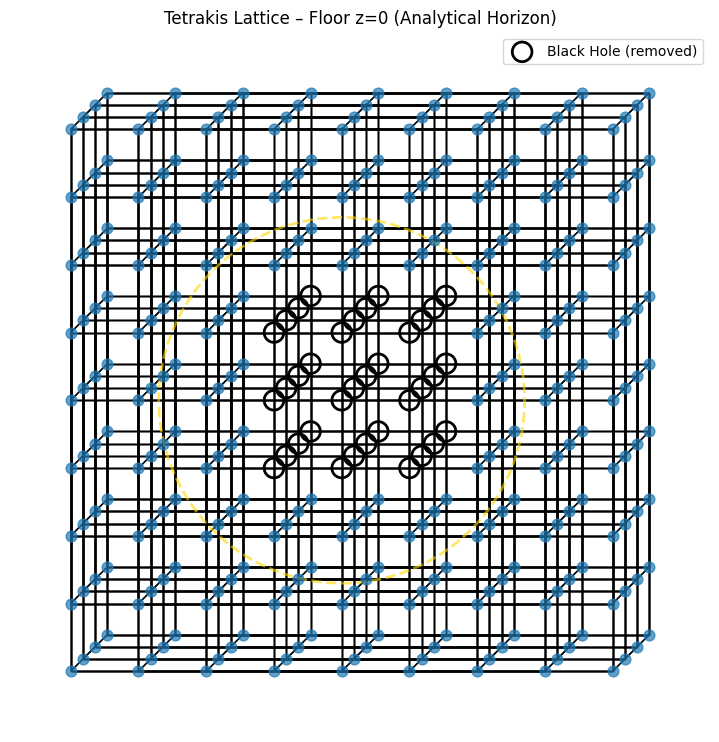

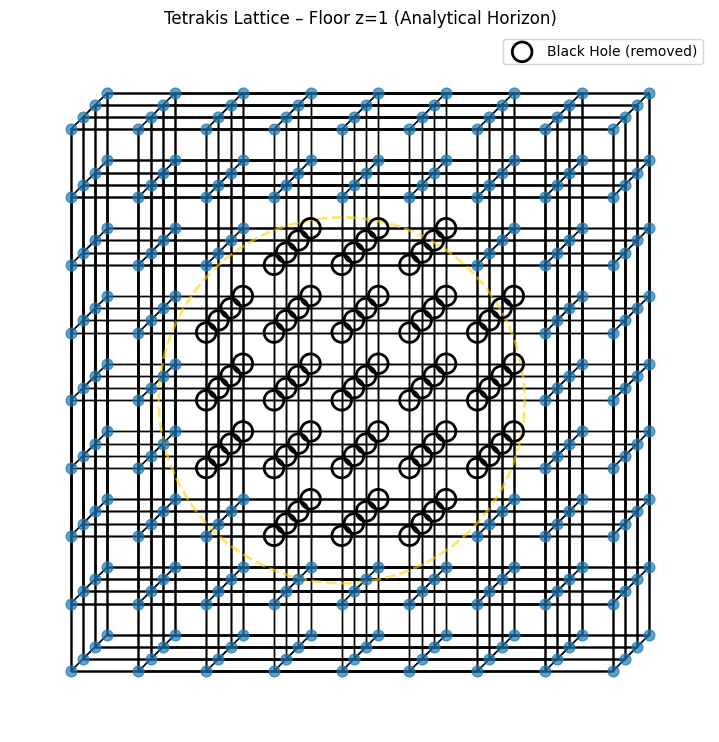

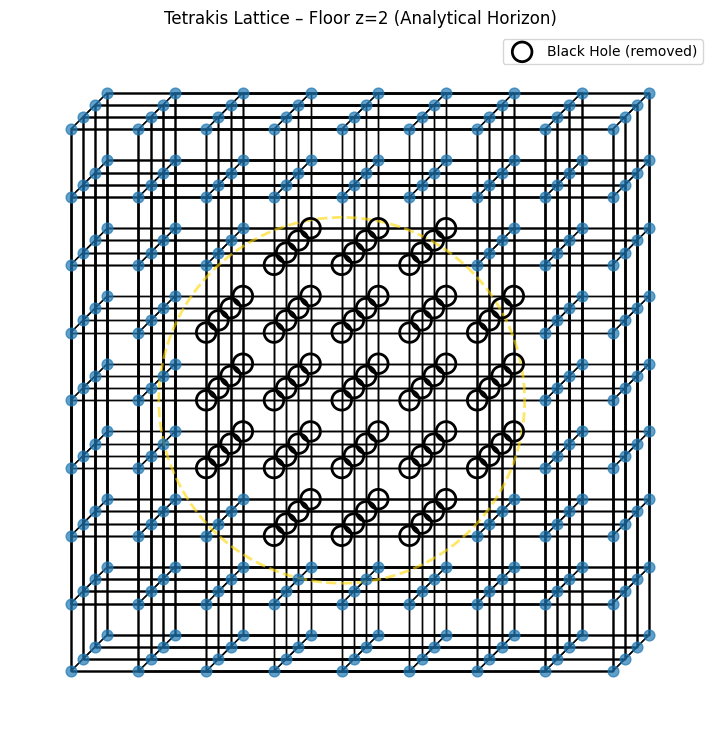

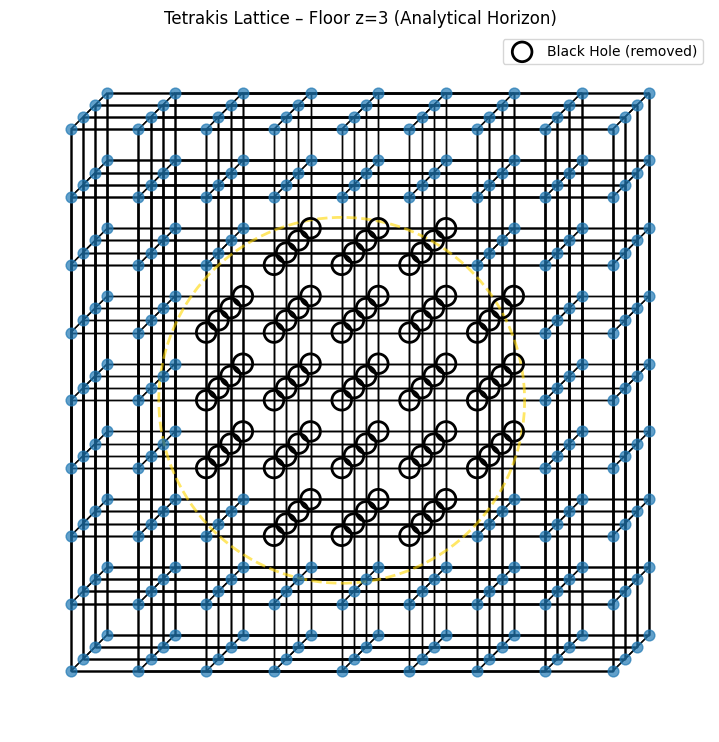

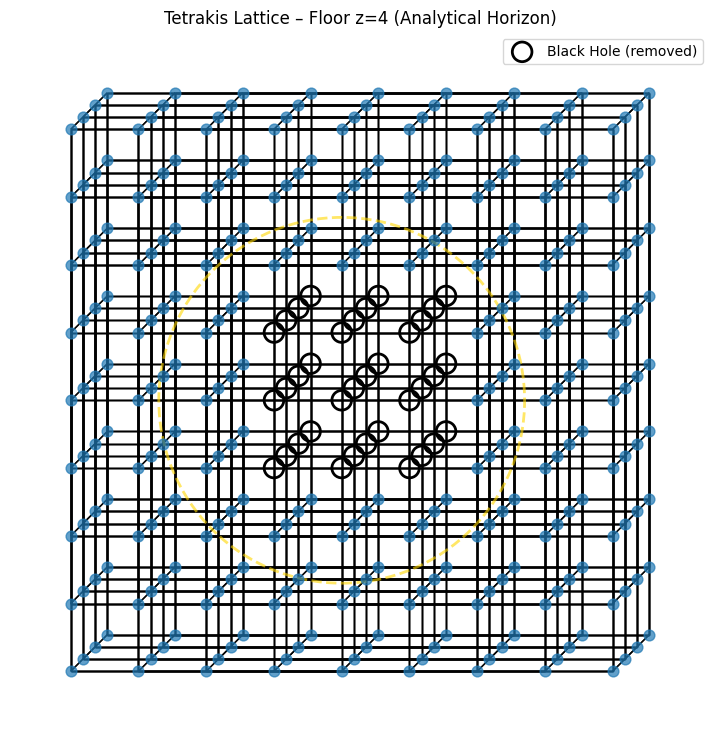

In [18]:
# ---- Overlay Event Horizon Circle ----
def plot_floor_with_circle(G, z, center, radius, highlight_nodes=None, boundary_nodes=None, figsize=(7,7)):
    nodes_on_layer = [n for n in G if n[2] == z]
    H = G.subgraph(nodes_on_layer)
    def node_pos(node):
        r, c, z, q = node
        offset = 0.18 * "ABCD".index(q)
        return (r + offset, c + offset)
    pos = {n: node_pos(n) for n in nodes_on_layer}
    plt.figure(figsize=figsize)
    nx.draw(H, pos, node_size=60, with_labels=False, alpha=0.7)
    # --- Plot removed nodes (black hole) as empty circles ---
    if highlight_nodes:
        nodes = [n for n in highlight_nodes if len(n) > 2 and n[2] == z]
        if nodes:
            def raw_node_pos(node):
                r, c, z, q = node
                offset = 0.18 * "ABCD".index(q)
                return (r + offset, c + offset)
            xs, ys = zip(*[raw_node_pos(n) for n in nodes])
            plt.scatter(xs, ys, s=200, c='none', edgecolors='black', linewidths=2, label='Black Hole (removed)', zorder=10)
    # --- Boundary nodes (event horizon) ---
    if boundary_nodes:
        nodes = [n for n in boundary_nodes if n[2] == z]
        if nodes:
            xs, ys = zip(*[pos[n] for n in nodes])
            plt.scatter(xs, ys, s=200, c='gold', edgecolors='red', label='Event Horizon', zorder=11)
    # --- Overlay event horizon as a circle (on row/col plane) ---
    r0, c0, _ = center
    circle = plt.Circle((r0, c0), radius, color='gold', fill=False, linewidth=2, linestyle='--', alpha=0.6)
    plt.gca().add_patch(circle)
    plt.title(f"Tetrakis Lattice – Floor z={z} (Analytical Horizon)")
    plt.axis('equal')
    plt.legend()
    plt.show()


for z in z_values:
    plot_floor_with_circle(
        G, z, bh_center, bh_radius,
        highlight_nodes=removed_nodes,
        boundary_nodes=horizon_nodes
    )


In [19]:
!pip install plotly


In [20]:
# ---- 3D Scatter Plot (Nodes & Horizon) ----
import plotly.graph_objects as go

x, y, z, color = [], [], [], []
for node in G.nodes:
    r, c, zz, q = node
    offset = 0.18 * "ABCD".index(q)
    x.append(r + offset)
    y.append(c + offset)
    z.append(zz)
    if node in horizon_nodes:
        color.append('gold')
    else:
        color.append('blue')

fig = go.Figure(data=[go.Scatter3d(
    x=x, y=y, z=z, mode='markers',
    marker=dict(size=3, color=color),
    text=[str(node) for node in G.nodes]
)])
fig.update_layout(title='Tetrakis Lattice (Event Horizon in Gold)', scene=dict(
    xaxis_title='Row',
    yaxis_title='Col',
    zaxis_title='Layer'
))
fig.show()
